# Capstone Project: Create a Customer Segmentation Report for Arvato Financial Services

In this project, you will analyze demographics data for customers of a mail-order sales company in Germany, comparing it against demographics information for the general population. You'll use unsupervised learning techniques to perform customer segmentation, identifying the parts of the population that best describe the core customer base of the company. Then, you'll apply what you've learned on a third dataset with demographics information for targets of a marketing campaign for the company, and use a model to predict which individuals are most likely to convert into becoming customers for the company. The data that you will use has been provided by our partners at Bertelsmann Arvato Analytics, and represents a real-life data science task.



## Importing Libraries

In [1]:
# import libraries here
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

# import some helper functions
from helpers import optimize_df, check_df_columns, dropna_df, check_distributions, feat_engr

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


## Part 1: Data Cleaning and Feature Engineering

There are four data files associated with this project:

- `Udacity_AZDIAS_052018.csv`: Demographics data for the general population of Germany; 891 211 persons (rows) x 366 features (columns).
- `Udacity_CUSTOMERS_052018.csv`: Demographics data for customers of a mail-order company; 191 652 persons (rows) x 369 features (columns).
- `Udacity_MAILOUT_052018_TRAIN.csv`: Demographics data for individuals who were targets of a marketing campaign; 42 982 persons (rows) x 367 (columns).
- `Udacity_MAILOUT_052018_TEST.csv`: Demographics data for individuals who were targets of a marketing campaign; 42 833 persons (rows) x 366 (columns).

Each row of the demographics files represents a single person, but also includes information outside of individuals, including information about their household, building, and neighborhood. Use the information from the first two files to figure out how customers ("CUSTOMERS") are similar to or differ from the general population at large ("AZDIAS"), then use your analysis to make predictions on the other two files ("MAILOUT"), predicting which recipients are most likely to become a customer for the mail-order company.

The "CUSTOMERS" file contains three extra columns ('CUSTOMER_GROUP', 'ONLINE_PURCHASE', and 'PRODUCT_GROUP'), which provide broad information about the customers depicted in the file. The original "MAILOUT" file included one additional column, "RESPONSE", which indicated whether or not each recipient became a customer of the company. For the "TRAIN" subset, this column has been retained, but in the "TEST" subset it has been removed; it is against that withheld column that your final predictions will be assessed in the Kaggle competition.

Otherwise, all of the remaining columns are the same between the three data files. For more information about the columns depicted in the files, you can refer to two Excel spreadsheets provided in the workspace. [One of them](./DIAS Information Levels - Attributes 2017.xlsx) is a top-level list of attributes and descriptions, organized by informational category. [The other](./DIAS Attributes - Values 2017.xlsx) is a detailed mapping of data values for each feature in alphabetical order.

In the below cell, we've provided some initial code to load in the first two datasets. Note for all of the `.csv` data files in this project that they're semicolon (`;`) delimited, so an additional argument in the [`read_csv()`](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.read_csv.html) call has been included to read in the data properly. Also, considering the size of the datasets, it may take some time for them to load completely.

You'll notice when the data is loaded in that a warning message will immediately pop up. Before you really start digging into the modeling and analysis, you're going to need to perform some cleaning. Take some time to browse the structure of the data and look over the informational spreadsheets to understand the data values. Make some decisions on which features to keep, which features to drop, and if any revisions need to be made on data formats. It'll be a good idea to create a function with pre-processing steps, since you'll need to clean all of the datasets before you work with them.

I'll first start by loading in the data. We will notice that there is a warning in columns 18 and 19 about mixed data type. We'll keep that in mind and deal with them shortly.

In [3]:
# load in the data
azdias = pd.read_csv("Udacity_AZDIAS_052018.csv", sep=';')
customers = pd.read_csv("Udacity_CUSTOMERS_052018.csv", sep=';')

/usr/local/lib/python3.6/dist-packages/IPython/core/interactiveshell.py:2718: DtypeWarning: Columns (18,19) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [4]:
pd.set_option('display.max_columns', 500)
# general population dataframe
azdias.head()

,LNR,AGER_TYP,AKT_DAT_KL,ALTER_HH,ALTER_KIND1,ALTER_KIND2,ALTER_KIND3,ALTER_KIND4,ALTERSKATEGORIE_FEIN,ANZ_HAUSHALTE_AKTIV,ANZ_HH_TITEL,ANZ_KINDER,ANZ_PERSONEN,ANZ_STATISTISCHE_HAUSHALTE,ANZ_TITEL,ARBEIT,BALLRAUM,CAMEO_DEU_2015,CAMEO_DEUG_2015,CAMEO_INTL_2015,CJT_GESAMTTYP,CJT_KATALOGNUTZER,CJT_TYP_1,CJT_TYP_2,CJT_TYP_3,CJT_TYP_4,CJT_TYP_5,CJT_TYP_6,D19_BANKEN_ANZ_12,D19_BANKEN_ANZ_24,D19_BANKEN_DATUM,D19_BANKEN_DIREKT,D19_BANKEN_GROSS,D19_BANKEN_LOKAL,D19_BANKEN_OFFLINE_DATUM,D19_BANKEN_ONLINE_DATUM,D19_BANKEN_ONLINE_QUOTE_12,D19_BANKEN_REST,D19_BEKLEIDUNG_GEH,D19_BEKLEIDUNG_REST,D19_BILDUNG,D19_BIO_OEKO,D19_BUCH_CD,D19_DIGIT_SERV,D19_DROGERIEARTIKEL,D19_ENERGIE,D19_FREIZEIT,D19_GARTEN,D19_GESAMT_ANZ_12,D19_GESAMT_ANZ_24,D19_GESAMT_DATUM,D19_GESAMT_OFFLINE_DATUM,D19_GESAMT_ONLINE_DATUM,D19_GESAMT_ONLINE_QUOTE_12,D19_HANDWERK,D19_HAUS_DEKO,D19_KINDERARTIKEL,D19_KONSUMTYP,D19_KONSUMTYP_MAX,D19_KOSMETIK,D19_LEBENSMITTEL,D19_LETZTER_KAUF_BRANCHE,D19_LOTTO,D19_NAHRUNGSERGAENZUNG,D19_RATGEBER,D19_REISEN,D19_SAMMELARTIKEL,D19_SCHUHE,D19_SONSTIGE,D19_SOZIALES,D19_TECHNIK,D19_TELKO_ANZ_12,D19_TELKO_ANZ_24,D19_TELKO_DATUM,D19_TELKO_MOBILE,D19_TELKO_OFFLINE_DATUM,D19_TELKO_ONLINE_DATUM,D19_TELKO_ONLINE_QUOTE_12,D19_TELKO_REST,D19_TIERARTIKEL,D19_VERSAND_ANZ_12,D19_VERSAND_ANZ_24,D19_VERSAND_DATUM,D19_VERSAND_OFFLINE_DATUM,D19_VERSAND_ONLINE_DATUM,D19_VERSAND_ONLINE_QUOTE_12,D19_VERSAND_REST,D19_VERSI_ANZ_12,D19_VERSI_ANZ_24,D19_VERSI_DATUM,D19_VERSI_OFFLINE_DATUM,D19_VERSI_ONLINE_DATUM,D19_VERSI_ONLINE_QUOTE_12,D19_VERSICHERUNGEN,D19_VOLLSORTIMENT,D19_WEIN_FEINKOST,DSL_FLAG,EINGEFUEGT_AM,EINGEZOGENAM_HH_JAHR,EWDICHTE,EXTSEL992,FINANZ_ANLEGER,FINANZ_HAUSBAUER,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_UNAUFFAELLIGER,FINANZ_VORSORGER,FINANZTYP,FIRMENDICHTE,GEBAEUDETYP,GEBAEUDETYP_RASTER,GEBURTSJAHR,GEMEINDETYP,GFK_URLAUBERTYP,GREEN_AVANTGARDE,HEALTH_TYP,HH_DELTA_FLAG,HH_EINKOMMEN_SCORE,INNENSTADT,KBA05_ALTER1,KBA05_ALTER2,KBA05_ALTER3,KBA05_ALTER4,KBA05_ANHANG,KBA05_ANTG1,KBA05_ANTG2,KBA05_ANTG3,KBA05_ANTG4,KBA05_AUTOQUOT,KBA05_BAUMAX,KBA05_CCM1,KBA05_CCM2,KBA05_CCM3,KBA05_CCM4,KBA05_DIESEL,KBA05_FRAU,KBA05_GBZ,KBA05_HERST1,KBA05_HERST2,KBA05_HERST3,KBA05_HERST4,KBA05_HERST5,KBA05_HERSTTEMP,KBA05_KRSAQUOT,KBA05_KRSHERST1,KBA05_KRSHERST2,KBA05_KRSHERST3,KBA05_KRSKLEIN,KBA05_KRSOBER,KBA05_KRSVAN,KBA05_KRSZUL,KBA05_KW1,KBA05_KW2,KBA05_KW3,KBA05_MAXAH,KBA05_MAXBJ,KBA05_MAXHERST,KBA05_MAXSEG,KBA05_MAXVORB,KBA05_MOD1,KBA05_MOD2,KBA05_MOD3,KBA05_MOD4,KBA05_MOD8,KBA05_MODTEMP,KBA05_MOTOR,KBA05_MOTRAD,KBA05_SEG1,KBA05_SEG10,KBA05_SEG2,KBA05_SEG3,KBA05_SEG4,KBA05_SEG5,KBA05_SEG6,KBA05_SEG7,KBA05_SEG8,KBA05_SEG9,KBA05_VORB0,KBA05_VORB1,KBA05_VORB2,KBA05_ZUL1,KBA05_ZUL2,KBA05_ZUL3,KBA05_ZUL4,KBA13_ALTERHALTER_30,KBA13_ALTERHALTER_45,KBA13_ALTERHALTER_60,KBA13_ALTERHALTER_61,KBA13_ANTG1,KBA13_ANTG2,KBA13_ANTG3,KBA13_ANTG4,KBA13_ANZAHL_PKW,KBA13_AUDI,KBA13_AUTOQUOTE,KBA13_BAUMAX,KBA13_BJ_1999,KBA13_BJ_2000,KBA13_BJ_2004,KBA13_BJ_2006,KBA13_BJ_2008,KBA13_BJ_2009,KBA13_BMW,KBA13_CCM_0_1400,KBA13_CCM_1000,KBA13_CCM_1200,KBA13_CCM_1400,KBA13_CCM_1401_2500,KBA13_CCM_1500,KBA13_CCM_1600,KBA13_CCM_1800,KBA13_CCM_2000,KBA13_CCM_2500,KBA13_CCM_2501,KBA13_CCM_3000,KBA13_CCM_3001,KBA13_FAB_ASIEN,KBA13_FAB_SONSTIGE,KBA13_FIAT,KBA13_FORD,KBA13_GBZ,KBA13_HALTER_20,KBA13_HALTER_25,KBA13_HALTER_30,KBA13_HALTER_35,KBA13_HALTER_40,KBA13_HALTER_45,KBA13_HALTER_50,KBA13_HALTER_55,KBA13_HALTER_60,KBA13_HALTER_65,KBA13_HALTER_66,KBA13_HERST_ASIEN,KBA13_HERST_AUDI_VW,KBA13_HERST_BMW_BENZ,KBA13_HERST_EUROPA,KBA13_HERST_FORD_OPEL,KBA13_HERST_SONST,KBA13_HHZ,KBA13_KMH_0_140,KBA13_KMH_110,KBA13_KMH_140,KBA13_KMH_140_210,KBA13_KMH_180,KBA13_KMH_210,KBA13_KMH_211,KBA13_KMH_250,KBA13_KMH_251,KBA13_KRSAQUOT,KBA13_KRSHERST_AUDI_VW,KBA13_KRSHERST_BMW_BENZ,KBA13_KRSHERST_FORD_OPEL,KBA13_KRSSEG_KLEIN,KBA13_KRSSEG_OBER,KBA13_KRSSEG_VAN,KBA13_KRSZUL_NEU,KBA13_KW_0_60,KBA13_KW_110,KBA13_KW_120,KBA13_KW_121,KBA13_KW_30,KBA13_KW_40,KBA13_KW_50,KBA13_KW_60,KBA13_KW_61_120,KBA13_KW_70,KBA13_KW_80,

In [5]:
# customers dataframe
customers.head()

,LNR,AGER_TYP,AKT_DAT_KL,ALTER_HH,ALTER_KIND1,ALTER_KIND2,ALTER_KIND3,ALTER_KIND4,ALTERSKATEGORIE_FEIN,ANZ_HAUSHALTE_AKTIV,ANZ_HH_TITEL,ANZ_KINDER,ANZ_PERSONEN,ANZ_STATISTISCHE_HAUSHALTE,ANZ_TITEL,ARBEIT,BALLRAUM,CAMEO_DEU_2015,CAMEO_DEUG_2015,CAMEO_INTL_2015,CJT_GESAMTTYP,CJT_KATALOGNUTZER,CJT_TYP_1,CJT_TYP_2,CJT_TYP_3,CJT_TYP_4,CJT_TYP_5,CJT_TYP_6,D19_BANKEN_ANZ_12,D19_BANKEN_ANZ_24,D19_BANKEN_DATUM,D19_BANKEN_DIREKT,D19_BANKEN_GROSS,D19_BANKEN_LOKAL,D19_BANKEN_OFFLINE_DATUM,D19_BANKEN_ONLINE_DATUM,D19_BANKEN_ONLINE_QUOTE_12,D19_BANKEN_REST,D19_BEKLEIDUNG_GEH,D19_BEKLEIDUNG_REST,D19_BILDUNG,D19_BIO_OEKO,D19_BUCH_CD,D19_DIGIT_SERV,D19_DROGERIEARTIKEL,D19_ENERGIE,D19_FREIZEIT,D19_GARTEN,D19_GESAMT_ANZ_12,D19_GESAMT_ANZ_24,D19_GESAMT_DATUM,D19_GESAMT_OFFLINE_DATUM,D19_GESAMT_ONLINE_DATUM,D19_GESAMT_ONLINE_QUOTE_12,D19_HANDWERK,D19_HAUS_DEKO,D19_KINDERARTIKEL,D19_KONSUMTYP,D19_KONSUMTYP_MAX,D19_KOSMETIK,D19_LEBENSMITTEL,D19_LETZTER_KAUF_BRANCHE,D19_LOTTO,D19_NAHRUNGSERGAENZUNG,D19_RATGEBER,D19_REISEN,D19_SAMMELARTIKEL,D19_SCHUHE,D19_SONSTIGE,D19_SOZIALES,D19_TECHNIK,D19_TELKO_ANZ_12,D19_TELKO_ANZ_24,D19_TELKO_DATUM,D19_TELKO_MOBILE,D19_TELKO_OFFLINE_DATUM,D19_TELKO_ONLINE_DATUM,D19_TELKO_ONLINE_QUOTE_12,D19_TELKO_REST,D19_TIERARTIKEL,D19_VERSAND_ANZ_12,D19_VERSAND_ANZ_24,D19_VERSAND_DATUM,D19_VERSAND_OFFLINE_DATUM,D19_VERSAND_ONLINE_DATUM,D19_VERSAND_ONLINE_QUOTE_12,D19_VERSAND_REST,D19_VERSI_ANZ_12,D19_VERSI_ANZ_24,D19_VERSI_DATUM,D19_VERSI_OFFLINE_DATUM,D19_VERSI_ONLINE_DATUM,D19_VERSI_ONLINE_QUOTE_12,D19_VERSICHERUNGEN,D19_VOLLSORTIMENT,D19_WEIN_FEINKOST,DSL_FLAG,EINGEFUEGT_AM,EINGEZOGENAM_HH_JAHR,EWDICHTE,EXTSEL992,FINANZ_ANLEGER,FINANZ_HAUSBAUER,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_UNAUFFAELLIGER,FINANZ_VORSORGER,FINANZTYP,FIRMENDICHTE,GEBAEUDETYP,GEBAEUDETYP_RASTER,GEBURTSJAHR,GEMEINDETYP,GFK_URLAUBERTYP,GREEN_AVANTGARDE,HEALTH_TYP,HH_DELTA_FLAG,HH_EINKOMMEN_SCORE,INNENSTADT,KBA05_ALTER1,KBA05_ALTER2,KBA05_ALTER3,KBA05_ALTER4,KBA05_ANHANG,KBA05_ANTG1,KBA05_ANTG2,KBA05_ANTG3,KBA05_ANTG4,KBA05_AUTOQUOT,KBA05_BAUMAX,KBA05_CCM1,KBA05_CCM2,KBA05_CCM3,KBA05_CCM4,KBA05_DIESEL,KBA05_FRAU,KBA05_GBZ,KBA05_HERST1,KBA05_HERST2,KBA05_HERST3,KBA05_HERST4,KBA05_HERST5,KBA05_HERSTTEMP,KBA05_KRSAQUOT,KBA05_KRSHERST1,KBA05_KRSHERST2,KBA05_KRSHERST3,KBA05_KRSKLEIN,KBA05_KRSOBER,KBA05_KRSVAN,KBA05_KRSZUL,KBA05_KW1,KBA05_KW2,KBA05_KW3,KBA05_MAXAH,KBA05_MAXBJ,KBA05_MAXHERST,KBA05_MAXSEG,KBA05_MAXVORB,KBA05_MOD1,KBA05_MOD2,KBA05_MOD3,KBA05_MOD4,KBA05_MOD8,KBA05_MODTEMP,KBA05_MOTOR,KBA05_MOTRAD,KBA05_SEG1,KBA05_SEG10,KBA05_SEG2,KBA05_SEG3,KBA05_SEG4,KBA05_SEG5,KBA05_SEG6,KBA05_SEG7,KBA05_SEG8,KBA05_SEG9,KBA05_VORB0,KBA05_VORB1,KBA05_VORB2,KBA05_ZUL1,KBA05_ZUL2,KBA05_ZUL3,KBA05_ZUL4,KBA13_ALTERHALTER_30,KBA13_ALTERHALTER_45,KBA13_ALTERHALTER_60,KBA13_ALTERHALTER_61,KBA13_ANTG1,KBA13_ANTG2,KBA13_ANTG3,KBA13_ANTG4,KBA13_ANZAHL_PKW,KBA13_AUDI,KBA13_AUTOQUOTE,KBA13_BAUMAX,KBA13_BJ_1999,KBA13_BJ_2000,KBA13_BJ_2004,KBA13_BJ_2006,KBA13_BJ_2008,KBA13_BJ_2009,KBA13_BMW,KBA13_CCM_0_1400,KBA13_CCM_1000,KBA13_CCM_1200,KBA13_CCM_1400,KBA13_CCM_1401_2500,KBA13_CCM_1500,KBA13_CCM_1600,KBA13_CCM_1800,KBA13_CCM_2000,KBA13_CCM_2500,KBA13_CCM_2501,KBA13_CCM_3000,KBA13_CCM_3001,KBA13_FAB_ASIEN,KBA13_FAB_SONSTIGE,KBA13_FIAT,KBA13_FORD,KBA13_GBZ,KBA13_HALTER_20,KBA13_HALTER_25,KBA13_HALTER_30,KBA13_HALTER_35,KBA13_HALTER_40,KBA13_HALTER_45,KBA13_HALTER_50,KBA13_HALTER_55,KBA13_HALTER_60,KBA13_HALTER_65,KBA13_HALTER_66,KBA13_HERST_ASIEN,KBA13_HERST_AUDI_VW,KBA13_HERST_BMW_BENZ,KBA13_HERST_EUROPA,KBA13_HERST_FORD_OPEL,KBA13_HERST_SONST,KBA13_HHZ,KBA13_KMH_0_140,KBA13_KMH_110,KBA13_KMH_140,KBA13_KMH_140_210,KBA13_KMH_180,KBA13_KMH_210,KBA13_KMH_211,KBA13_KMH_250,KBA13_KMH_251,KBA13_KRSAQUOT,KBA13_KRSHERST_AUDI_VW,KBA13_KRSHERST_BMW_BENZ,KBA13_KRSHERST_FORD_OPEL,KBA13_KRSSEG_KLEIN,KBA13_KRSSEG_OBER,KBA13_KRSSEG_VAN,KBA13_KRSZUL_NEU,KBA13_KW_0_60,KBA13_KW_110,KBA13_KW_120,KBA13_KW_121,KBA13_KW_30,KBA13_KW_40,KBA13_KW_50,KBA13_KW_60,KBA13_KW_61_120,KBA13_KW_70,KBA13_KW_80,

Since the azdias dataframe has a lot of columns and rows, it takes up more than 2 GB in memory. This causes some RAM issues later on in the notebook when I attempt to do imputing and scaling. Hence, I decided to create a simple function to downcast int64 to unint and float64 to float32 where possible. Upon downcasting, we can see that the dwoncasted version of the azdias dataframe uses 1+ GB in memory, which is much smaller.

In [6]:
# downcast column datatyoe where possible
azdias = optimize_df(azdias)
azdias.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891221 entries, 0 to 891220
Columns: 366 entries, LNR to ALTERSKATEGORIE_GROB
dtypes: float32(267), int64(4), object(6), uint16(1), uint32(1), uint8(87)
memory usage: 1.0+ GB


In [7]:
customers = optimize_df(customers)
customers.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 191652 entries, 0 to 191651
Columns: 369 entries, LNR to ALTERSKATEGORIE_GROB
dtypes: float32(267), int64(4), object(8), uint16(1), uint32(1), uint8(88)
memory usage: 229.9+ MB


Next, I'll check if the population and customers dataframe have the same number of columns. It turns out that the customers dataframe has 3 extra columns compared to the population dataframe. Hence, we drop those columns.

In [8]:
check_df_columns(azdias, customers)

df1 has these extra columns:  set()
df2 has these extra columns:  {'PRODUCT_GROUP', 'ONLINE_PURCHASE', 'CUSTOMER_GROUP'}


In [9]:
# drop the extra columns from customers df
customers = customers.drop(columns=['ONLINE_PURCHASE', 'CUSTOMER_GROUP', 'PRODUCT_GROUP'])

### Assess missing data

Now, we move on to checking the missing values in the dataframes. Since there are so many columns, we'll check if all those columns are useful. If most of the values in the columns are actually missing, then it doesn't convey much useful information for us and we can drop it.

We notice that most columns have less than 20000 values missing and a couple of columns have more than 80000 values missing.

Text(0.5, 1.0, 'Histogram of total values missing per column')

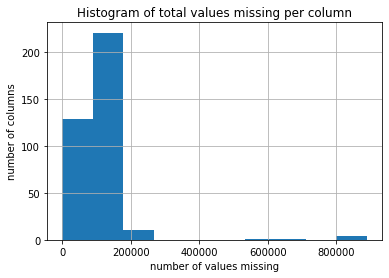

In [10]:
# hist of total values missing per column
azdias.isna().sum().hist()
plt.xlabel("number of values missing")
plt.ylabel("number of columns")
plt.title("Histogram of total values missing per column")

In the cell below, I have listed out the columns with percentage of data missing in descending order. We see that some columns have up to 99% of data missing!  
I will drop columns with more than half of the data missing.

In [11]:
# get percentage of data missing for each column
# ascending order, top 20
azdias.isna().sum().sort_values(ascending=False).head(20)/len(azdias)

ALTER_KIND4                    0.998648
ALTER_KIND3                    0.993077
ALTER_KIND2                    0.966900
ALTER_KIND1                    0.909048
EXTSEL992                      0.733996
KK_KUNDENTYP                   0.655967
ALTERSKATEGORIE_FEIN           0.295041
D19_LETZTER_KAUF_BRANCHE       0.288495
D19_LOTTO                      0.288495
D19_VERSI_ONLINE_QUOTE_12      0.288495
D19_BANKEN_ONLINE_QUOTE_12     0.288495
D19_SOZIALES                   0.288495
D19_GESAMT_ONLINE_QUOTE_12     0.288495
D19_KONSUMTYP                  0.288495
D19_TELKO_ONLINE_QUOTE_12      0.288495
D19_VERSAND_ONLINE_QUOTE_12    0.288495
KBA05_MOTOR                    0.149597
KBA05_MOD8                     0.149597
KBA05_MOD4                     0.149597
KBA05_MOD3                     0.149597
dtype: float64

I now check the missingness of values for each row. Most rows have less than about 25 missing values. There are a few rows that have more than 200 values (out of 366) missing.

Text(0.5, 1.0, 'Histogram of total values missing per row')

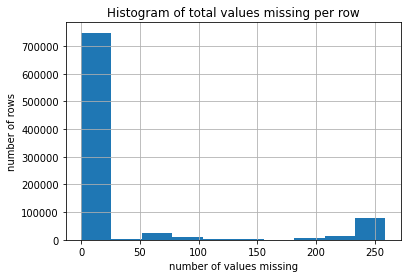

In [12]:
# hist of total values missing per row
azdias.isna().sum(axis=1).hist()
plt.xlabel("number of values missing")
plt.ylabel("number of rows")
plt.title("Histogram of total values missing per row")

The table below shows the percentage of missing values per row in descending order. I will later drop rows with more than 50 values missing

In [13]:
# get percentage of data missing for each column
# ascending order, top 20
azdias.isna().sum(axis=1).sort_values(ascending=False).head(20)/len(azdias.columns)

55664     0.707650
537799    0.707650
350182    0.707650
373501    0.707650
826869    0.707650
739769    0.704918
475330    0.704918
5099      0.704918
140317    0.704918
522174    0.704918
629707    0.704918
716386    0.704918
57866     0.704918
23667     0.704918
332962    0.704918
347712    0.704918
255742    0.704918
228624    0.699454
376576    0.691257
376536    0.691257
dtype: float64

Since there are many columns, the columns might be correlated to each other. We find that 'KBA13_HERST_SONST` and `KBA13_FAB_SONSTIGE` has a correlation value of 1, which makes one of the redundant, so I will drop the former.

In [14]:
# get correlation values for each pair of column in df
corr = azdias.corr()

# get only the upper triangular part of correlation matrix (excluding diagonal)
# removes repeated pairs
corr = corr.where(np.triu(np.ones(corr.shape), k=1).astype(np.bool))
corr.unstack().transpose().sort_values(ascending=False).dropna()

# KBA13_HERST_SONST and KBA13_FAB_SONSTIGE have correlation coeff of 1

KBA13_HERST_SONST            KBA13_FAB_SONSTIGE          1.000000
LP_LEBENSPHASE_GROB          LP_LEBENSPHASE_FEIN         0.989961
LP_FAMILIE_GROB              LP_FAMILIE_FEIN             0.984100
LP_STATUS_GROB               LP_STATUS_FEIN              0.982411
PLZ8_GBZ                     KBA13_GBZ                   0.979854
                                                           ...   
KBA13_SITZE_5                KBA13_SITZE_4              -0.867961
D19_VERSAND_ONLINE_QUOTE_12  D19_VERSAND_ONLINE_DATUM   -0.868449
D19_GESAMT_DATUM             D19_GESAMT_ANZ_24          -0.868989
D19_GESAMT_ONLINE_QUOTE_12   D19_GESAMT_ONLINE_DATUM    -0.870384
ORTSGR_KLS9                  GEMEINDETYP                -0.934515
Length: 64616, dtype: float64

### Data cleaning

The cell below cleans the azdias and customer dataframe as described above, i.e. dealing with the mixed datatypes in columns 18 an 19, converting values like 'XX' to np.nan, and dropping rows and columns with a lot of missing values

In [28]:
azdias_clean, customer_clean = dropna_df(azdias, customers)

cleaning columns:  Index(['CAMEO_DEUG_2015', 'CAMEO_INTL_2015'], dtype='object')
cleaning column: CAMEO_DEU_2015
cleaning columns:  ['AGER_TYP', 'HEALTH_TYP', 'SHOPPER_TYP', 'VERS_TYP']
dropping columns:  ['AGER_TYP', 'ALTER_KIND1', 'ALTER_KIND2', 'ALTER_KIND3', 'ALTER_KIND4', 'EXTSEL992', 'KK_KUNDENTYP', 'KBA13_HERST_SONST']


After removing some rows and columns, we would like to have a quick check to ensure that the distribution of data before and after dropping does not look too different. I plotted 5 random columns from the azdias dataframe and they look similar.

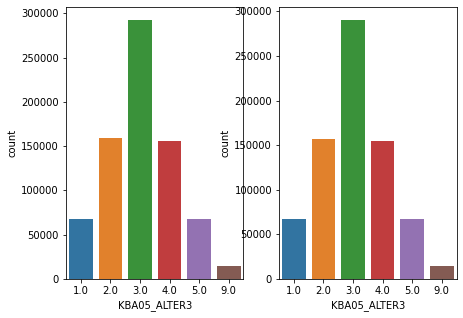

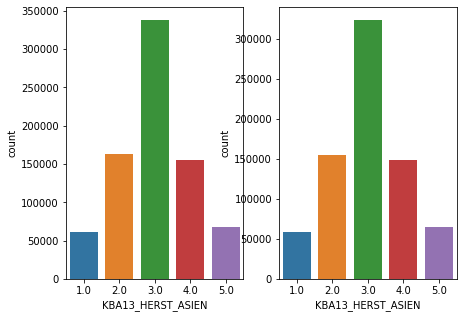

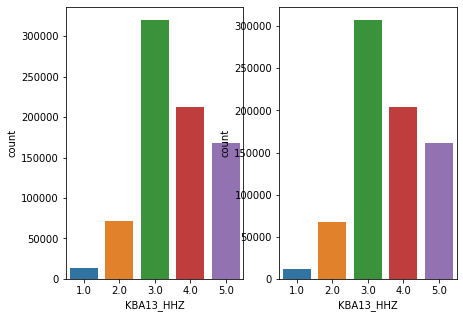

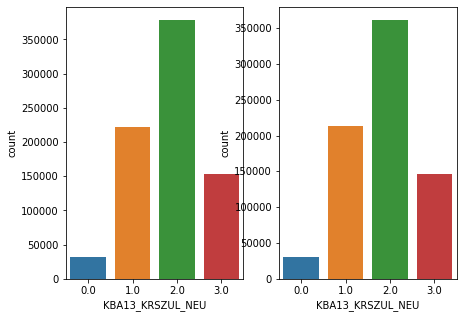

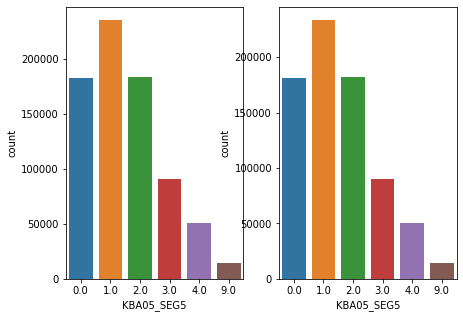

In [22]:
num_cols = len(azdias_clean.columns)

for plot in range(5):
  # get a random column index
  i = np.random.randint(num_cols)
  # plot that column before and after dropping values
  check_distributions(azdias, azdias_clean, azdias_clean.columns[i])

# the distributions look similar

### Feature Engineering

I will now attempt some feature engineering to extract some new information from the data.

The 'PRAEGENDE_JUGENDJAHRE' column contains 3 types of information: decade of movement(e.g. 40ies, 50ies), avantgarde/mainstream and O/W. Since some of the categories contain either O or W while some contain both, I will only create 2 new variables to capture the decade of movement and the avantgarde/mainstream movement.

The 'CAMEO_INTL_2015' feature contains the wealth stage and family type. I will separate the two-digits code into 2 one-digit codes as new ordinal variables.

'LP_LEBENSPHASE_FEIN' contains information on income and age. There are many categories which look similar in this column, which will massively increase the number of columns in the dataset if I one-hot encode it (too many columns keeps causing my kernel to crash). Hence, I will extract the age from 'LP_LEBENSPHASE_FEIN' into categories and then drop it, and the income information can be obtained from 'LP_LEBENSPHASE_GROB'

For 'EINGEFUEGT_AM', since it is a timestamp, I will extract the year from it.

There are a few columns such as 'LP_FAMILIE_GROB' and 'LP_STATUS_GROB' that have different categorical values that match to the same meaning. For example, in 'LP_FAMILIE_GROB', value 3, 4 and 5 means 'single parent'. I will replace these values such that they have the same value.


### Encoding Categorical Features

'OST_WEST_KZ' is a binary categorical variable with values W and O. I will encode them as 0 and 1. For categorical variables with more than 2 values (such as 'ZABEOTYP'), I will one hot encode them.

I will however drop the 'D19_LETZTER_KAUF_BRANCHE' as there are quite a lot of categories.

The feature engineering and categorical-columns encoding are combined in the feat_engr function. After this process, we do a quick check to make sure both the azdias and customer dataframes still have the same columns.

In [30]:
azdias_clean = feat_engr(azdias_clean)
customer_clean = feat_engr(customer_clean)
check_df_columns(azdias_clean, customer_clean)

Same columns in both df


### Filling Missing Values

To deal with missing values, I will use the SimpleImputer in sklearn to impute them with the mode. I only apply the imputer to columns with missing values and not the whole dataframe as it helps to avoid the kernel from crashing. I first check that the azdias and customer dataframe have the same columns with missing values. The same imputer is fit on the azdias data and then used to transform both the azdias and customer data.



In [31]:
# get the columns in azdias & customers that have NaN values
az_col_with_nan = azdias_clean.columns[azdias_clean.isnull().any()].to_list()
cust_col_with_nan = customer_clean.columns[azdias_clean.isnull().any()].to_list()

#check and see if they are the same
if set(az_col_with_nan) == set(cust_col_with_nan):
    print("Both dfs have same columns that have NaN values")

Both dfs have same columns that have NaN values


In [32]:
#since both df have same columns with NaNs, column without NaNs will be the same, so just do it once
cols_with_no_nan = azdias_clean.columns[~azdias_clean.isnull().any()].to_list()

In [33]:
from sklearn.impute import SimpleImputer
imputer = SimpleImputer(strategy= 'most_frequent')
imputer.fit(azdias_clean[az_col_with_nan])

# df that has only columns with missing value
azdias_imputed = pd.DataFrame(imputer.transform(azdias_clean[az_col_with_nan]), columns=az_col_with_nan)
# combine columns that were imputed and columns without missing values to a full dataframe again
azdias_combined = azdias_imputed.merge(azdias_clean[cols_with_no_nan], left_index=True, right_index=True)

# write to csv for future use
azdias_combined.to_csv('azdias_combined_new.csv', index=False)

In [37]:
# do the same steps to the customer df

customer_imputed = pd.DataFrame(imputer.transform(customer_clean[az_col_with_nan]), columns=az_col_with_nan)
customer_combined = customer_imputed.merge(customer_clean[cols_with_no_nan], left_index=True, right_index=True)

customer_combined.to_csv('customer_combined_new.csv', index=False)

Quick check that the number of NaNs in both the azdias and customer dataframes are now 0

In [40]:
sum(azdias_combined.isna().sum())

0

In [41]:
sum(customer_combined.isna().sum())

0